<a href="https://colab.research.google.com/github/aashishpiitkEigenlytics/document_classification_/blob/main/resnet18_holistic_fine_tune_doceye_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os, math, sys
import glob, itertools
import argparse, random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models import vgg19
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid

import plotly
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

random.seed(42)
import warnings
warnings.filterwarnings("ignore")

import math
from pathlib import Path
from torchsummary import summary
import torchvision
from PIL import Image, ImageOps

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# number of epochs of training
n_epochs = 50
# name of the dataset
dataset_path = "/content/train/test/"
# size of the batches
batch_size = 16
# adam: learning rate
lr = 0.00008
# adam: decay of first order momentum of gradient
b1 = 0.5
# adam: decay of second order momentum of gradient
b2 = 0.999
# epoch from which to start lr decay
decay_epoch = 100
# number of cpu threads to use during batch generation
n_cpu = 8
# high res. image height
hr_height = 64
# high res. image width
hr_width = 64
# number of image channels
channels = 1

# os.makedirs("images", exist_ok=True)
# os.makedirs("saved_models", exist_ok=True)

cuda = torch.cuda.is_available()
hr_shape = (hr_height, hr_width)



In [ ]:
! unzip -q /content/drive/MyDrive/rotated_data_doceye.zip

In [ ]:
doc2label = {
    'Payslips':0,
    'Invoices Generic':1,
    'Bank Statements':2,
    'Death Certificate':3,
    'Doctor_Prescription_Sample':4,
    'Form16':5,
    'Handwritten Forms':6,
    'Handwritten Tranining texts':7,
    'ITR':8,
    'Mall Customer Invoices Image sample':9,
    'Medical Record_sample':10,
    'Motor Claims_Garage Invoices sample':11,
    'PAN Sample Images':12,
    'Passport':13,
    'Policy Schedule':14,
    'Tele MER':15
}
count = {
    'Payslips':0,
    'Invoices Generic':1,
    'Bank Statements':2,
    'Death Certificate':3,
    'Doctor_Prescription_Sample':4,
    'Form16':5,
    'Handwritten Forms':6,
    'Handwritten Tranining texts':7,
    'ITR':8,
    'Mall Customer Invoices Image sample':9,
    'Medical Record_sample':10,
    'Motor Claims_Garage Invoices sample':11,
    'PAN Sample Images':12,
    'Passport':13,
    'Policy Schedule':14,
    'Tele MER':15
}

In [ ]:
train_path = []
# count1 = 0
# count2 = 0
for path in Path('/content/content/content/data1/Sample_Data_For_DocEye').rglob('*.png'):
  target = str(str(path).split('/')[-2])
  # if(target == 'Motor Claims_Garage Invoices sample'):
  #   count1+=1
  #   if(count1>200):
  #     continue
  # if(target == 'Handwritten Forms'):
  #   count2+=1
  #   if(count2>200):
  #     continue
  count[target]+=1
  if(count[target] > 75):
    continue
  train_path.append((path, doc2label[target]))

In [ ]:
class ImageDataset(Dataset):
  def __init__(self, files):
    #super(ImageDataset, self)

    self.files = files
    self.trans = transforms.Compose([
                                transforms.Grayscale(),
                                transforms.Resize((780,600)), 
                                transforms.ToTensor(),
                                
    ])
    self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])
    
    self.trans2 = transforms.Resize((227,227))

    #self.trans1 = transforms.ToTensor()
  
  def __getitem__(self, index):
    img = Image.open(self.files[index % len(self.files)][0])
    target = self.files[index % len(self.files)][1]
    
    output_dict = {
        'targets' : torch.tensor(target),
        'holistic' : self.create_holistic(img),
    }

    return output_dict
  
  def create_header(self, x):
    # trans1 = transforms.ToTensor()
    x = self.trans(x)

    x = x[:][:, :256, :]
    return self.trans2(x)


  def create_right_half(self, x):
    x = self.trans(x)

    x = x[:][:, 100:-100, -300:]
    return self.trans2(x)
  def create_left_half(self, x):
    x = self.trans(x)

    x = x[:][:, 100:-100, :300]
    return self.trans2(x)
  def create_footer(self, x):
    x = self.trans(x)

    x = x[:][:, -256:, :]
    return self.trans2(x)

  def create_holistic(self, x):
    x = self.trans(x)
    x = x.repeat_interleave(3, dim=0)
    return self.normalize(x)

  def __len__(self):
      return len(self.files)


In [ ]:
# train_path = train_path[:len(train_path)//5]

In [ ]:
len(train_path)

825

In [ ]:
## incorporate the labels somehow when preparing the dataset usign ImageDataset

In [ ]:
train_paths, test_paths = train_test_split(train_path, test_size=0.1, random_state=42)
train_paths = train_paths[:len(train_paths)]
test_paths = test_paths[:len(test_paths)]

#train_paths, test_paths = train_test_split(sorted(glob.glob(dataset_path + "/*.*")), test_size=0.02, random_state=42)
train_dataloader = DataLoader(ImageDataset(train_paths), batch_size=batch_size, shuffle=True, num_workers=n_cpu)
test_dataloader = DataLoader(ImageDataset(test_paths), batch_size=int(batch_size), shuffle=True, num_workers=n_cpu)

In [ ]:
len(train_dataloader)

197

In [ ]:
print(len(test_dataloader))

22


In [ ]:
# resnet18 = torchvision.models.resnet18(pretrained=True)

In [ ]:
# print(resnet18)

In [ ]:
# resent18.children()

In [ ]:
# for child_counter, child in enumerate(resnet18.children()):
#   print(child)

In [ ]:
# for name, param in list(resnet18.named_parameters())[:-17]:
#       print(name, param.shape, param.requires_grad)

In [ ]:
# feature_extractor = nn.Sequential(*list(resnet18.children())[:-1])
# print(feature_extractor)

In [ ]:
class ResNet18_fine_tune(nn.Module):
  def __init__(self):
    super(ResNet18_fine_tune, self).__init__()

    self.resnet18_model = torchvision.models.resnet18(pretrained=True)
    self.feature_extractor = nn.Sequential(*list(self.resnet18_model.children())[:-1])
    
    for (name, param) in (list(self.feature_extractor.named_parameters())[:-60]):
      param.requires_grad = False
    for (name, param) in (list(self.feature_extractor.named_parameters())[-60:]):
      param.requires_grad = True

    self.classifier = nn.Sequential(nn.Linear(512, 128, bias=True),
                                    nn.ReLU(),
                                    nn.Linear(128,16, bias=True))

  def forward(self, x):
    x=self.feature_extractor(x)
    
    x = self.classifier(torch.flatten(x, start_dim=1))
    return x


In [ ]:
resnet18_fine_tune = ResNet18_fine_tune().to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


In [ ]:
# print(resnet18_fine_tune)

In [ ]:
# output = resnet18_fine_tune(torch.randn(3,3,780,600))

In [ ]:
# print(output.shape)

In [ ]:
# print(type(vgg16_fine_tune_last_layer.feature_extractor.named_parameters()))

In [ ]:
for name, param in resnet18_fine_tune.named_parameters():
    if param.requires_grad:
        print(name)

resnet18_model.conv1.weight
resnet18_model.bn1.weight
resnet18_model.bn1.bias
resnet18_model.layer1.0.conv1.weight
resnet18_model.layer1.0.bn1.weight
resnet18_model.layer1.0.bn1.bias
resnet18_model.layer1.0.conv2.weight
resnet18_model.layer1.0.bn2.weight
resnet18_model.layer1.0.bn2.bias
resnet18_model.layer1.1.conv1.weight
resnet18_model.layer1.1.bn1.weight
resnet18_model.layer1.1.bn1.bias
resnet18_model.layer1.1.conv2.weight
resnet18_model.layer1.1.bn2.weight
resnet18_model.layer1.1.bn2.bias
resnet18_model.layer2.0.conv1.weight
resnet18_model.layer2.0.bn1.weight
resnet18_model.layer2.0.bn1.bias
resnet18_model.layer2.0.conv2.weight
resnet18_model.layer2.0.bn2.weight
resnet18_model.layer2.0.bn2.bias
resnet18_model.layer2.0.downsample.0.weight
resnet18_model.layer2.0.downsample.1.weight
resnet18_model.layer2.0.downsample.1.bias
resnet18_model.layer2.1.conv1.weight
resnet18_model.layer2.1.bn1.weight
resnet18_model.layer2.1.bn1.bias
resnet18_model.layer2.1.conv2.weight
resnet18_model.layer

In [ ]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, resnet18_fine_tune.parameters()), 
                             lr=lr, betas=(b1, b2))

criterion = nn.CrossEntropyLoss()

In [ ]:
# torch.cuda.empty_cache()

In [ ]:
# ## loading the weights
# checkpoint = torch.load("/content/drive/MyDrive/vgg16_last_layer_fine_tune_rvl_cdip_checkpt16.pt",map_location=torch.device(device))

# vgg16_fine_tune_last_layer.load_state_dict(checkpoint['vgg16_fine_tune_last_layer'])
# # vgg16_fine_tune_last_layer.load_state_dict()
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# vgg16_fine_tune_last_layer.train()

In [ ]:
# for param_tensor in vgg16_fine_tune_last_layer.state_dict():
#   print(param_tensor, "\t", vgg16_fine_tune_last_layer.state_dict()[param_tensor].size())

In [ ]:
# # save only model.state_dict()['last_layer.weight'] and model.state_dict()['last_layer.bias']
# new_state_dict = {}
# layers = ['last_layer.weight', 'last_layer.bias']
# for layer in layers:
#   print(vgg16_fine_tune_last_layer.state_dict()[layer].shape)
#   new_state_dict[layer] = vgg16_fine_tune_last_layer.state_dict()[layer]

In [ ]:
# for param_tensor in new_state_dict:
#   print(param_tensor, "\t", new_state_dict[param_tensor].size())

In [ ]:
# ## loading the weights
# checkpoint = torch.load("/content/drive/MyDrive/vgg16_with_normalisation_last_layer/checkpt8.pt",map_location=torch.device(device))

# new_state_dict = checkpoint['new_state_dict']
# old_dict = vgg16_fine_tune_last_layer.state_dict()
# layers = ['last_layer.0.weight', 'last_layer.0.bias', 'last_layer.2.weight', 'last_layer.2.bias', 'last_layer.4.weight', 'last_layer.4.bias']
# for layer in layers:
#   old_dict[layer] = new_state_dict[layer] 
# vgg16_fine_tune_last_layer.load_state_dict(old_dict)


# #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# vgg16_fine_tune_last_layer.train()



In [ ]:
## we will save and load this dictionary only

In [ ]:
def accuracy(x, targets):
  # receive the outputs of linear layer
  # first apply softmax then take argmax to know the index
  # then compare
  # input will be (batch_size, )
  probs = nn.functional.softmax(x)
  labels = torch.argmax(probs, dim=1)

  count=0
  for label, target in zip(labels, targets):
    #print(label, target)
    if(label.item() == target.item()):
      count+=1
  
  return count/labels.shape[0]



In [ ]:
# temp = torch.randn(2,1,227,227)

In [ ]:
# _mean = temp[:,0,:,:].mean(axis=0)
# print(_mean.shape)

In [ ]:
## load the weights till epoch 9
checkpoint = torch.load("/content/drive/MyDrive/resnet18_fine_tune_all_four_blocks/checkpt8.pt",map_location=torch.device(device))
resnet18_fine_tune.load_state_dict(checkpoint['resnet18_fine_tune'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
train_losses, test_losses = [], []
train_acc, test_acc = [], []
test_counter = [idx*len(test_dataloader.dataset) for idx in range(1, n_epochs+1)]
train_counter = [idx*len(train_dataloader.dataset) for idx in range(1, n_epochs+1)]

n_epochs = 24
for epoch in range(n_epochs):

  # Training loop
  loss = 0
  acc = 0
  tqdm_bar = tqdm(train_dataloader, desc=f'Training Epoch {epoch} ', total=int(len(train_dataloader)))

  for batch_idx, imgs in enumerate(tqdm_bar):

    optimizer.zero_grad()


    resnet18_fine_tune.train();

    for key in imgs:
      imgs[key] = imgs[key].to(device)

    holistic_img = imgs['holistic']
    targets = imgs['targets']

    prediction = resnet18_fine_tune(holistic_img.to(device))

    loss_calc = criterion(prediction.to(device), targets.to(device))

    loss_calc.backward()
    optimizer.step()

    loss += loss_calc.item()
    acc += accuracy(prediction.to(device), targets.to(device))
    tqdm_bar.set_postfix(loss=loss/(batch_idx+1), acc = acc/(batch_idx+1))

  train_losses.append(loss/len(train_dataloader)) ## divided by total number of batches



  


  ## Testing loop
  loss = 0
  acc = 0
  tqdm_bar = tqdm(test_dataloader, desc=f'Testing Epoch {epoch} ', total=int(len(test_dataloader)))

  for batch_idx, imgs in enumerate(tqdm_bar):

    resnet18_fine_tune.eval();
    
    for key in imgs:
      imgs[key] = imgs[key].to(device)

    holistic_img = imgs['holistic']
    targets = imgs['targets']

    prediction = resnet18_fine_tune(holistic_img.to(device))

    loss_calc = criterion(prediction.to(device), targets.to(device))

    loss += loss_calc.item()
    acc += accuracy(prediction.to(device), targets.to(device))
    tqdm_bar.set_postfix(loss=loss/(batch_idx+1), acc = acc/(batch_idx+1))

  test_losses.append(loss/len(test_dataloader)) ## divided by total number of batches

  if(True):
    torch.save({
          
          'resnet18_fine_tune' : resnet18_fine_tune.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'train_loss' : train_losses[-1],
          'test_loss' : test_losses[-1],
          'epoch': epoch+1,
          }, f"/content/drive/MyDrive/resnet18_doceye_fine_tune_holistic/checkpt{epoch+1}.pt")

KeyboardInterrupt: ignored

In [ ]:
## load the weights till epoch 9
checkpoint = torch.load("/content/drive/MyDrive/resnet18_doceye_fine_tune_holistic/checkpt7.pt",map_location=torch.device(device))
resnet18_fine_tune.load_state_dict(checkpoint['resnet18_fine_tune'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
import re
num = re.compile('\w{1,}')

In [ ]:
def predict_folder_images():
  for path in Path('/content/custom_images').rglob("*.*"):
    s = str(path)
    img = Image.open(s)
    pred = predict(s)

    folder_path = '/'.join(s.split('/')[:-1]) + '/'
    img_name = num.findall(s.split('/')[-1])[0]

    img.save(folder_path+img_name+f'_predicted_{pred}.png')

In [ ]:
predict_folder_images()

In [ ]:
def predict(path):
  img = Image.open(path)
  from matplotlib.pyplot import figure

  #figure(figsize=(18, 16), dpi=80)
  #plt.imshow(img)

  trans = transforms.Compose([
                                transforms.Grayscale(),
                                transforms.Resize((780,600)), 
                                transforms.ToTensor()])
  imt = trans(img).to(device)

  output = resnet18_fine_tune(imt.unsqueeze(0).repeat_interleave(3, dim=1))

  pred = nn.functional.softmax(output, dim=1)

  return torch.argmax(pred)
  #print(torch.argmax(pred), pred)

In [ ]:
! zip -r -q /content/custom_images.zip /content/custom_images

In [ ]:
## classifying every grid document as ITR/motor claim garage invoice
## even ITR as motor invoice
## form16, ITR contain a lot of ITR images so the model is biased towards them
## not recognizing death certificate
## recongnining bank statements
## the classes which have more varied data are predicted more correctly
## almost everything into bank/itr
## other classes differ very little from these and also have a lot less data
## invoices and payslips not being recognized

tensor(8, device='cuda:0') tensor([[0.0585, 0.0324, 0.1403, 0.0194, 0.0088, 0.1809, 0.0227, 0.0012, 0.2079,
         0.0192, 0.0674, 0.1136, 0.0012, 0.0014, 0.0969, 0.0282]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)


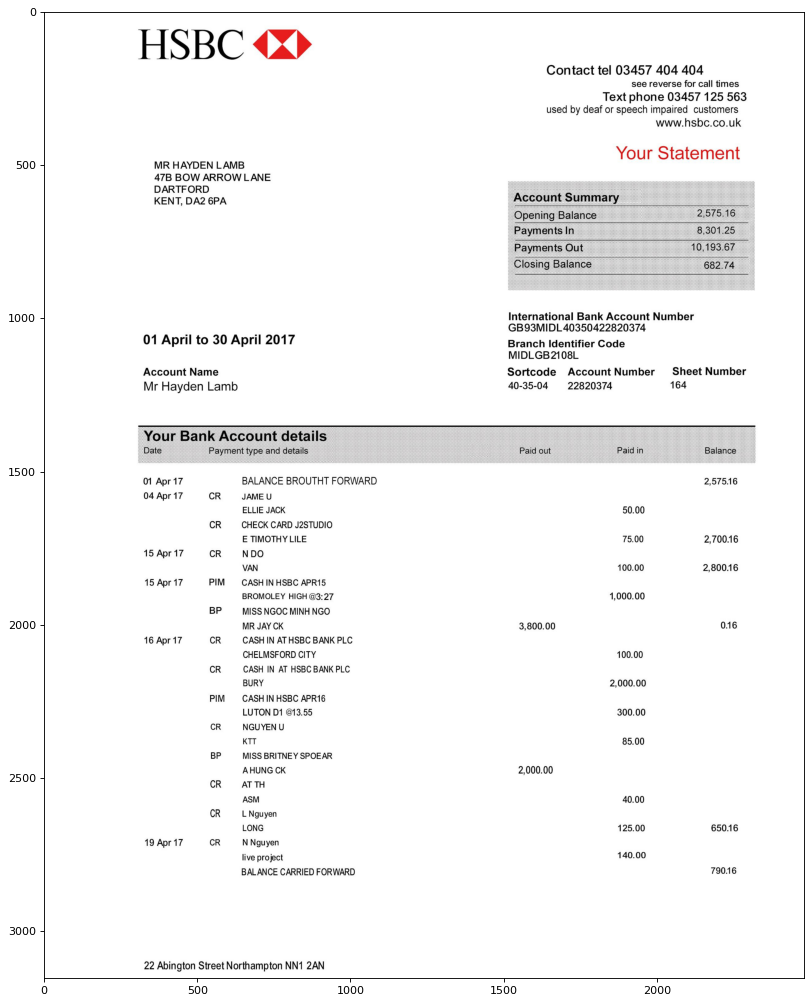

In [ ]:
predict('/content/5dd7faaee6096c243be0a452e4d3565e.jpg')

In [ ]:
# ## load the weights till epoch 9
# checkpoint = torch.load("/content/drive/MyDrive/resnet18_fine_tune_all_four_blocks/checkpt10.pt",map_location=torch.device(device))
# resnet18_fine_tune.load_state_dict(checkpoint['resnet18_fine_tune'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
# train_losses, test_losses = [], []
# train_acc, test_acc = [], []
# test_counter = [idx*len(test_dataloader.dataset) for idx in range(1, n_epochs+1)]
# train_counter = [idx*len(train_dataloader.dataset) for idx in range(1, n_epochs+1)]

# n_epochs = 25
# for epoch in range(10,n_epochs):

#   # Training loop
#   loss = 0
#   acc = 0
#   tqdm_bar = tqdm(train_dataloader, desc=f'Training Epoch {epoch} ', total=int(len(train_dataloader)))

#   for batch_idx, imgs in enumerate(tqdm_bar):

#     optimizer.zero_grad()


#     resnet18_fine_tune.train();

#     for key in imgs:
#       imgs[key] = imgs[key].to(device)

#     holistic_img = imgs['holistic']
#     targets = imgs['targets']
#     # _mean = holistic_img[:,0,:,:].mean(axis=0)
#     # _std  = holistic_img[:,0,:,:].std(axis=0)
#     # holistic_img[:,0,:,:] = (holistic_img[:,0,:,:]-_mean)/_std

#     ## convert the 1 channel image to 3 channel image
#     #holistic_img_3 = holistic_img.repeat_interleave(3, dim=1)
#     #holistic_img_3[:, 1:3, :, :] = 0

#     prediction = resnet18_fine_tune(holistic_img.to(device))

#     loss_calc = criterion(prediction.to(device), targets.to(device))

#     loss_calc.backward()
#     optimizer.step()

#     loss += loss_calc.item()
#     acc += accuracy(prediction.to(device), targets.to(device))
#     tqdm_bar.set_postfix(loss=loss/(batch_idx+1), acc = acc/(batch_idx+1))

#   train_losses.append(loss/len(train_dataloader)) ## divided by total number of batches



  


#   ## Testing loop
#   loss = 0
#   acc = 0
#   tqdm_bar = tqdm(test_dataloader, desc=f'Testing Epoch {epoch} ', total=int(len(test_dataloader)))

#   for batch_idx, imgs in enumerate(tqdm_bar):

#     resnet18_fine_tune.eval();
    
#     for key in imgs:
#       imgs[key] = imgs[key].to(device)

#     holistic_img = imgs['holistic']
#     targets = imgs['targets']
#     # _mean = holistic_img[:,0,:,:].mean(axis=0)
#     # _std  = holistic_img[:,0,:,:].std(axis=0)
#     # holistic_img[:,0,:,:] = (holistic_img[:,0,:,:]-_mean)/_std
    
#     ## convert the 1 channel image to 3 channel image
#     #holistic_img_3 = holistic_img.repeat_interleave(3, dim=1)
    
#     #holistic_img_3[:, 1:3, :, :] = 0
    
#     prediction = resnet18_fine_tune(holistic_img.to(device))

#     loss_calc = criterion(prediction.to(device), targets.to(device))

#     loss += loss_calc.item()
#     acc += accuracy(prediction.to(device), targets.to(device))
#     tqdm_bar.set_postfix(loss=loss/(batch_idx+1), acc = acc/(batch_idx+1))

#   test_losses.append(loss/len(test_dataloader)) ## divided by total number of batches


#   #new_state_dict = {}
#   # layers = ['last_layer.weight', 'last_layer.bias']
#   # for layer in layers:
#   #   new_state_dict[layer] = vgg16_fine_tune_last_layer.state_dict()[layer]

#   if(True):
#     torch.save({
          
#           'resnet18_fine_tune' : resnet18_fine_tune.state_dict(),
#           'optimizer_state_dict': optimizer.state_dict(),
#           'train_loss' : train_losses[-1],
#           'test_loss' : test_losses[-1],
#           'epoch': epoch+1,
#           }, f"/content/drive/MyDrive/resnet18_fine_tune_all_four_blocks/checkpt{epoch+1}.pt")

In [ ]:
# train_paths, test_paths = train_test_split(train_path, test_size=0.1, random_state=42)
# #train_paths = train_paths[:len(train_paths)]
# test_paths = test_paths[:len(test_paths)]

# #train_dataloader = DataLoader(ImageDataset(train_paths), batch_size=batch_size, shuffle=True, num_workers=n_cpu)
# test_dataloader = DataLoader(ImageDataset(test_paths), batch_size=int(batch_size), shuffle=True, num_workers=n_cpu)

In [ ]:
# ######## Evaluation loop
# train_losses, test_losses = [], []
# train_acc, test_acc = [], []
# test_counter = [idx*len(test_dataloader.dataset) for idx in range(1, n_epochs+1)]
# train_counter = [idx*len(train_dataloader.dataset) for idx in range(1, n_epochs+1)]

# n_epochs = 1
# for epoch in range(n_epochs):
#   ## Testing loop
#   loss = 0
#   acc = 0
#   tqdm_bar = tqdm(test_dataloader, desc=f'Testing Epoch {epoch} ', total=int(len(test_dataloader)))

#   for batch_idx, imgs in enumerate(tqdm_bar):

#     resnet18_fine_tune.eval();
    
#     for key in imgs:
#       imgs[key] = imgs[key].to(device)

#     holistic_img = imgs['holistic']
#     targets = imgs['targets']
    
#     prediction = resnet18_fine_tune(holistic_img.to(device))

#     loss_calc = criterion(prediction.to(device), targets.to(device))

#     loss += loss_calc.item()
#     acc += accuracy(prediction.to(device), targets.to(device))
#     tqdm_bar.set_postfix(loss=loss/(batch_idx+1), acc = acc/(batch_idx+1))

#   test_losses.append(loss/len(test_dataloader)) ## divided by total number of batches